# Cointégration et construction de stratégie action

Projet mené par **Adrien Cortes** et **Louis-Marie Lovichi**

## I. Remarque préliminaire

Les détails supplémentaires sont tous disponibles dans le rapport, mais voici quelques remarques qu'il est important de garder en mémoire pour la suite des expériences numériques.

Cet article propose différentes applications de stratégies d'investissement basées sur la cointégration, on note : 

- une stratégie classique de suivi d'indices;
- une stratégie d'actions long-short market neutral;
- une combinaison des deux approches précédentes.

L'idée de la première stratégie est de reproduire les rendements et la volatilité d'un indice de référence spécifique (exemple du CAC40), c'est-à-dire un portefeuille ayant de propriétés similaires à celui de l'indice en termes de rendements, volatilité et corrélation; tandis que les deux stratégies suivantes visent à minimiser la volatilité et générer des rendements stables quelles que soient les conditions de marché.

L'avantage de se baser sur la cointégration pour l'optimisation de portefeuille est qu'elle permet d'utiliser toutes les informations comprises dans les prix et de construire des poids sur le comportement long terme des actions. Par ailleurs, l'estimation des poids du portefeuille basée sur la cointégration permet une certaine stabilité, cela tend à ignorer les mouvements de prix à court-terme tels que le bruit.

L'objet de ces expériences numériques est de montrer que les techniques de cointégration produisent des résultats prometteurs dans différentes stratégies d'investissement que cela soit le tracking d'indice ou les stratégies long-short market neutral.

## II. Expériences numériques transposées au marché français.

### 0. Data 

On pré-processe ici les données du CAC40 de 2001 à nos jours. Pour certaines valeurs, les données sont manquantes à partir d'un certain rang, on les complète naïvement par la dernière valeur présente dans cette colonne.

In [368]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from utils_long_short import calculer_rendement_iteratif, perform_regression, rebalance_and_evaluate, calculate_annual_global_metrics

In [321]:
file_path = '../data/CAC.xlsx'
sheet_name_weights = 'Worksheet'
sheet_name_data = 'Data'

df_weights = pd.read_excel(file_path, sheet_name=sheet_name_weights, index_col=0)
dict_weights_CAC = df_weights['Poids'].to_dict()

df_data = pd.read_excel(file_path, sheet_name=sheet_name_data, index_col=0)
df_data = df_data.fillna(method='ffill')
df_data

,CAC Index,OR FP Equity,DG FP Equity,STLAP FP Equity,TTE FP Equity,DSY FP Equity,AI FP Equity,ERF FP Equity,CS FP Equity,BNP FP Equity,...,VIE FP Equity,SAN FP Equity,GLE FP Equity,SU FP Equity,AIR FP Equity,URW FP Equity,LR FP Equity,ACA FP Equity,RI FP Equity,STMPA FP Equity
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,5798.90,88.80,16.4820,12.750,39.0814,1900-01-06 18:43:12,29.1563,1900-01-03 06:57:36,36.7977,1900-02-13 22:32:00.960000,...,1900-02-12 14:27:18.720000,1900-03-08 19:47:51.360000,1900-02-26 20:33:56.160000,1900-02-06 17:09:44.640000,1900-01-23 11:45:36,1900-07-14 16:33:36,1900-01-19 18:00:00,14.9562,1900-01-22 13:29:08.160000,42.590
2001-01-03,5684.05,84.80,16.0770,13.147,38.7113,1900-01-06 08:52:48,28.9480,1900-01-02 22:06:14.400000,36.2781,1900-02-13 01:42:05.760000,...,1900-02-12 14:27:18.720000,1900-03-07 21:07:20.640000,1900-02-26 06:49:06.240000,1900-02-06 07:39:38.880000,1900-01-23 04:33:36,1900-07-12 04:33:36,1900-01-23 05:16:48,15.7941,1900-01-22 16:26:41.280000,40.100
2001-01-04,5815.99,84.20,15.4634,13.189,37.9218,1900-01-07 02:24:00,29.7243,1900-01-03 12:54:43.200000,36.2072,1900-02-14 14:44:00.960000,...,1900-02-08 11:26:09.600000,1900-03-04 03:36:34.560000,1900-03-01 16:34:19.200000,1900-02-06 02:54:31.680000,1900-01-23 04:48:00,1900-07-09 16:48:00,1900-01-23 01:40:48,16.1275,1900-01-23 10:11:51.360000,45.200
2001-01-05,5758.02,81.30,16.2979,12.933,37.9958,1900-01-06 18:57:36,29.9136,1900-01-03 14:24:00,34.9082,1900-02-15 02:53:05.280000,...,1900-02-09 02:03:50.400000,1900-03-02 01:28:59.520000,1900-03-01 16:34:19.200000,1900-02-05 09:41:02.400000,1900-01-21 21:36:00,1900-07-10 21:36:00,1900-01-22 12:00:00,15.9473,1900-01-22 19:24:14.400000,44.250
2001-01-08,5732.80,80.40,15.7947,12.521,38.4646,1900-01-06 12:14:24,30.2733,1900-01-03 14:45:36,34.5067,1900-02-14 19:21:47.520000,...,1900-02-10 03:56:35.520000,1900-03-01 13:32:52.800000,1900-03-03 06:38:44.160000,1900-02-06 20:43:35.040000,1900-01-22 19:12:00,1900-07-12 07:40:48,1900-01-23 04:48:00,15.8932,1900-01-22 19:24:14.400000,43.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,7911.60,451.15,115.5200,24.360,59.1300,43.295,185.4200,58.02,32.0600,56.22,...,30.35,88.74,22.47,210,147.28,67.42,92.1,12.5740,159.85,42.205
2024-02-23,7966.68,450.20,116.7600,24.360,59.6600,43.33,189.5000,58.64,32.3000,56.39,...,30.19,89.71,22.495,205.5,147.96,67.42,92.1,12.5740,157.95,41.545
2024-02-26,7929.82,450.65,116.2000,24.360,59.1900,43.19,189.7400,54.74,32.3750,55.34,...,29.52,89.28,22.255,207.4,147.34,67.42,92.1,12.5740,157.15,41.380


In [322]:
dict_weights_CAC

{'AI FP Equity': 0.0534,
 'AIR FP Equity': 0.0476,
 'ALO FP Equity': 0.0022,
 'MT NA Equity': 0.0077,
 'CS FP Equity': 0.0327,
 'BNP FP Equity': 0.0426,
 'EN FP Equity': 0.0038,
 'CAP FP Equity': 0.0182,
 'CA FP Equity': 0.0055,
 'SGO FP Equity': 0.0178,
 'ML FP Equity': 0.0133,
 'ACA FP Equity': 0.0079,
 'BN FP Equity': 0.0217,
 'DSY FP Equity': 0.0173,
 'EDEN FP Equity': 0.0078,
 'ENGI FP Equity': 0.017,
 'EL FP Equity': 0.0332,
 'ERF FP Equity': 0.0043,
 'RMS FP Equity': 0.0352,
 'KER FP Equity': 0.0173,
 'OR FP Equity': 0.0619,
 'LR FP Equity': 0.0146,
 'MC FP Equity': 0.1064,
 'ORA FP Equity': 0.0111,
 'RI FP Equity': 0.019,
 'PUB FP Equity': 0.0112,
 'RNO FP Equity': 0.0045,
 'SAF FP Equity': 0.0335,
 'SAN FP Equity': 0.0585,
 'SU FP Equity': 0.0601,
 'GLE FP Equity': 0.0104,
 'STLAP FP Equity': 0.029,
 'STMPA FP Equity': 0.0168,
 'TEP FP Equity': 0.0046,
 'HO FP Equity': 0.0081,
 'TTE FP Equity': 0.09,
 'URW FP Equity': 0.0046,
 'VIE FP Equity': 0.0101,
 'DG FP Equity': 0.0351,


### 1. Index Tracking

On crée une classe objet qui nous permet de construire notre portfolio qui a pour but de tracker l'indice du CAC40.

In [435]:
class IndexTracking():

    def __init__(self, 
                 assets_selected: list[str],
                 df_data: pd.DataFrame):
        
        self.assets_selected = assets_selected
        self.df_data = df_data[['CAC Index'] + assets_selected]

    # effectue le backtest sur une période de calibration donnée
    def back_test(self,
                  calibration_period: int=252) -> pd.DataFrame:

        nb_iterations = (len(self.df_data) - calibration_period)//10 + 1

        dico_weights = {}
        weights = []
        date = []
        for i in range(nb_iterations):

            model = LinearRegression(positive=True)
            
            df = self.df_data.iloc[i*10: calibration_period + i*10]
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.fillna(1)
            df = df.applymap(lambda x: np.log(x))
            y = df['CAC Index']
            X = df.drop(columns=['CAC Index'])
            X = np.array(X).reshape(-1, len(self.assets_selected))
            model.fit(X, y)
            weights.append(model.coef_/np.sum(model.coef_))
            date.append(df.index[-1])
        weights = np.array(weights).T
        for (i, asset) in enumerate(self.assets_selected):
            dico_weights[asset] = weights[i]

        return pd.DataFrame(dico_weights, index=date)
    
    # calcule les rendements cumulés
    def get_cumulative_returns(self,
                               df_weights: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        
        df_data_adapt = self.df_data.loc[df_weights.index][['CAC Index'] + self.assets_selected].pct_change()
        
        values = 0
        for asset in df_weights.columns:

            values += np.array(df_weights[asset])[:-1]*np.array(df_data_adapt[asset])[1:]
            
        returns_tracking = np.cumsum(values)
        returns_tracking = returns_tracking/np.max(returns_tracking)
        returns_cac = np.cumsum(df_data_adapt['CAC Index'])/np.max(np.cumsum(df_data_adapt['CAC Index']))

        return returns_cac, returns_tracking
    
    # trace les poids du portfolio
    def plot_weights(self,
                     df_weights):
        
        # Calculer les poids cumulatifs
        df_cumsum = df_weights.iloc[:, 0:].cumsum(axis=1)

        # Tracer le graphique de zone empilée
        plt.figure(figsize=(12, 8))
        for (i, asset) in enumerate(df_weights.columns):
            if i == 0:
                asset0 = asset
                plt.fill_between(df_weights.index, 0, df_cumsum[asset], label=asset)
            else:
                plt.fill_between(df_weights.index, df_cumsum[asset0], df_cumsum[asset], label=asset)
                asset0 = asset

        plt.xlabel('Temps')
        plt.ylabel('Poids dans le Tracking')
        plt.title('Répartition des poids des actifs dans le portefeuille')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.show()

    # trace les rendements du portfolio
    def plot_returns(self,
                     df_weights: pd.DataFrame,
                     returns_tracking,
                     returns_cac):
        
        colors = sns.color_palette('husl', 2)

        plt.figure(figsize=(12, 8))
        plt.plot(df_weights.index[1:], returns_tracking, label='Tracking', color=colors[0])
        plt.plot(df_weights.index, returns_cac, label='Benchmark', color=colors[1])

        plt.xlabel('Temps')
        plt.ylabel('Rendements cumulatifs')
        plt.title('Tracé des rendements cumulatifs de la réplication')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.show()

In [436]:
# on sélectionne les assets qui permettront de tracker les indices

assets = list(dict_weights_CAC.keys())
assets_selectable = [asset for asset in assets if asset in df_data.columns]
nb_assets = 25
indices_aleatoires = random.sample(range(len(assets_selectable)), nb_assets)
assets_selected = [assets_selectable[i] for i in indices_aleatoires]

# on sélectionne les assets qui présentent suffisamment de données au vue du dataset donné, en effet, certains assets fournis ne permettent pas une telle analyse en raison de l'absence des données et provoquent une instabilité des poids du portfolio

assets_selected = ['ACA FP Equity', 'OR FP Equity', 'DG FP Equity', 'STLAP FP Equity', 'TTE FP Equity', 'STMPA FP Equity', 'ML FP Equity', 'ALO FP Equity', 'CS FP Equity', 'SAF FP Equity']

On crée alors le tracker et on calcule les poids associés.

In [441]:
index = IndexTracking(assets_selected, df_data)
index.df_data
df_weights = index.back_test(calibration_period=1250)

On trace l'évolution des poids associés.

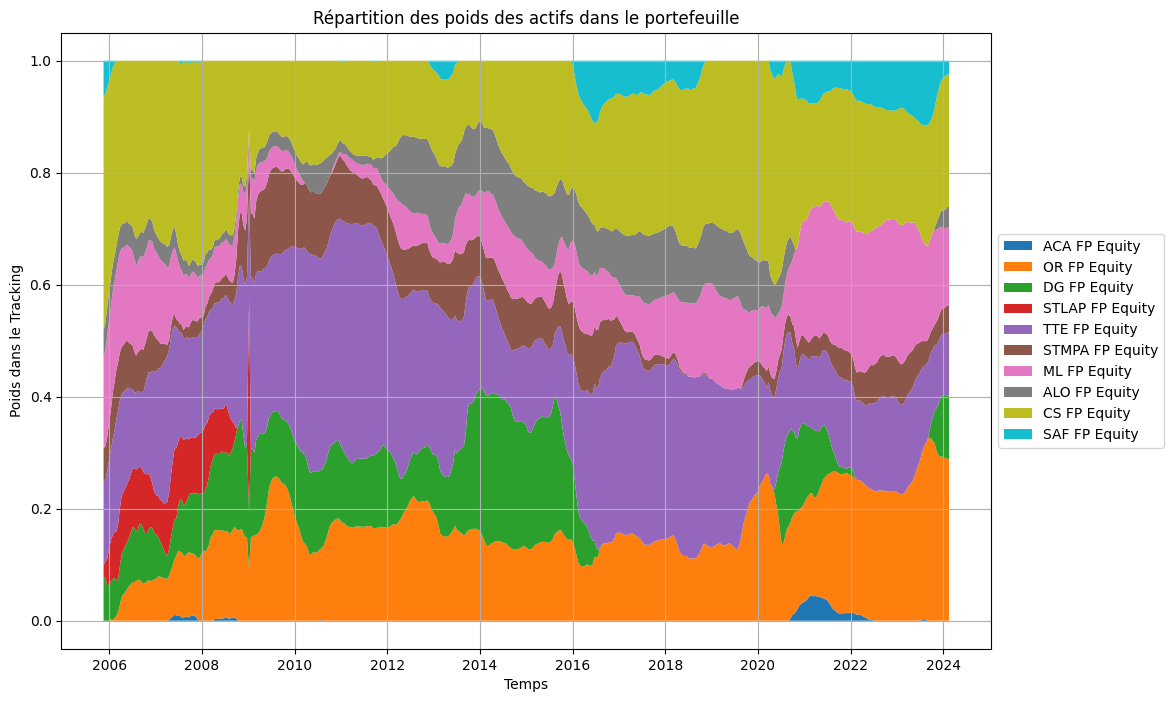

In [442]:
index.plot_weights(df_weights)

On calcule les rendements cumulés associés.

In [443]:
returns_cac, returns_tracking = index.get_cumulative_returns(df_weights)

On trace les rendements cumulés associés.

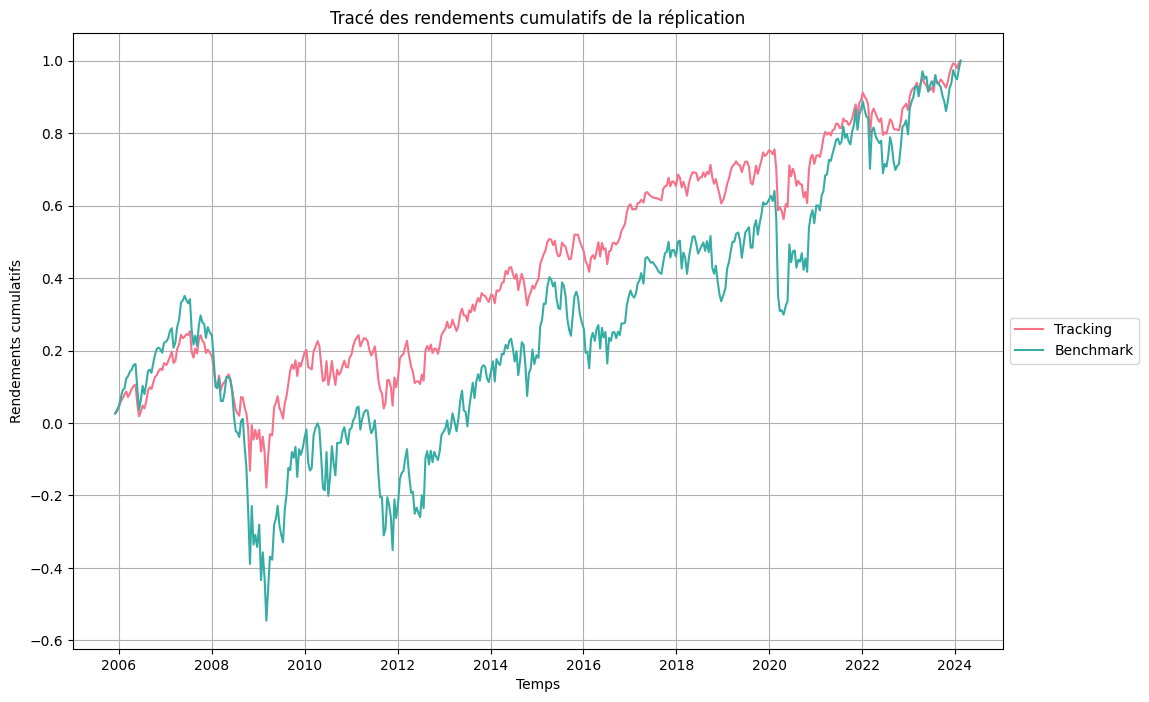

In [444]:
index.plot_returns(df_weights,
                   returns_tracking,
                   returns_cac)

### 2. Long-short market neutral strategy

On ajoute au benchmark en rendement supplémentaire de x% distrbué uniformément sur les jours. On va prendre x valant 5%, 10% et 15%. On le retire et on l'ajoute pour contruire un 'index_plus' et un 'index_minus'. 

#### a) Création d'un index_plus et d'un index_minus

La fonction calculer rendement iteratif permet de d'ajouter un pourcentage au rendement du cac40. 

In [366]:
# on choisit de travailler sur uniquement quelques valeurs  
# 'CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
# 'TTE FP Equity'

data = df_data[['CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
                'TTE FP Equity','STMPA FP Equity','ML FP Equity','ALO FP Equity','CS FP Equity',
                'SAF FP Equity']]

In [369]:
df_plus_5_5y = calculer_rendement_iteratif(data, '2008-01-03', 5) #dataframe, date_depart, augmentation par an en pourcentage
df_min_5_5y = calculer_rendement_iteratif(data, '2008-01-03', -5)# 5%


df_plus_10_5y = calculer_rendement_iteratif(data, '2008-01-03', 10) #dataframe, date_depart, augmentation par an en pourcentage
df_min_10_5y = calculer_rendement_iteratif(data, '2008-01-03', -10) #10% 


df_plus_15_5y = calculer_rendement_iteratif(data, '2008-01-03', 15) #dataframe, date_depart, augmentation par an en pourcentage
df_min_15_5y = calculer_rendement_iteratif(data, '2008-01-03', -15) #15% d'augmentation ici 

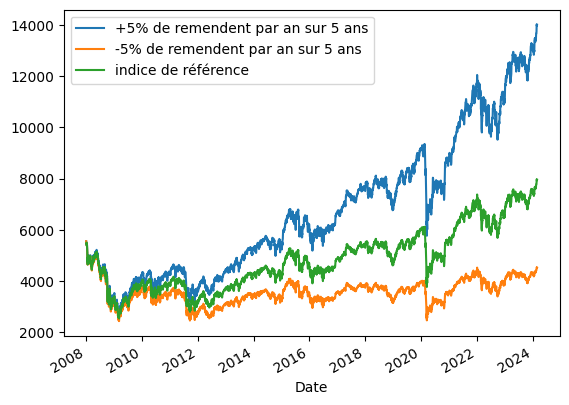

In [370]:
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")
df_data.loc["2008-01-05 ":]["CAC Index"].plot(label="indice de référence")
plt.legend()
plt.show() 

La nouvelle cointegration décrite dans l'article s'écrit de la manière suivante :

In [377]:
params_plus_intercept, params_plus, residuals_plus = perform_regression(df_plus_15_5y)
params_moins_intercept, params_moins, residuals_moins = perform_regression(df_min_15_5y)
print('Les paramètres fit sont pour l\'index_plus:\n', params_plus)
print()
print('Les paramètres fit sont pour l\'index_moins: \n', params_moins)

Les paramètres fit sont pour l'index_plus:
 ACA FP Equity      0.015460
OR FP Equity       0.694168
DG FP Equity       0.320110
STLAP FP Equity    1.115386
TTE FP Equity      0.193951
STMPA FP Equity    0.164210
ML FP Equity      -0.090386
ALO FP Equity     -0.107308
CS FP Equity       0.051497
SAF FP Equity      0.061183
dtype: float64

Les paramètres fit sont pour l'index_moins: 
 ACA FP Equity     -0.143938
OR FP Equity      -0.131720
DG FP Equity      -0.326795
STLAP FP Equity    2.115149
TTE FP Equity      0.362494
STMPA FP Equity   -0.049583
ML FP Equity       0.270297
ALO FP Equity      0.212982
CS FP Equity       0.460918
SAF FP Equity     -0.244641
dtype: float64


#### b) Backtest de la stratégie

On va ici ré-éstimer tous les 10 jours nos poids sur la période [date départ, date précédente+10]. On va à chaque fois que l'on rebalance nos poids s'assurer que le test ADF est correct, i.e. que la cointégration fonctionne proprement, et nous allons plotter ce graphique. On va aussi calculer le prix que l'on obtient en soustrayant les couts. Cela nous permettra d'avoir un rendement en temps réel de notre stratégie, vs un rendement de l'indice. Le fait d'avoir le prix en continu devrait nous permettre aussi d'avoir la volatilité, la possibilité de calculer la skewness et la kurtosis, ainsi que les sharpe ratio. 

In [378]:
# le backtest de nos différentes stratégies 
adf_critic_value_5, adf_stats_list_5,replication_max_5,replication_min_5 = rebalance_and_evaluate(df_plus_5_5y,df_min_5_5y,'2008-01-03',1)
adf_critic_value_10, adf_stats_list_10,replication_max_10,replication_min_10 = rebalance_and_evaluate(df_plus_10_5y,df_min_10_5y,'2008-01-03',1)
adf_critic_value_15, adf_stats_list_15,replication_max_15,replication_min_15 = rebalance_and_evaluate(df_plus_15_5y,df_min_15_5y,'2008-01-03',1)

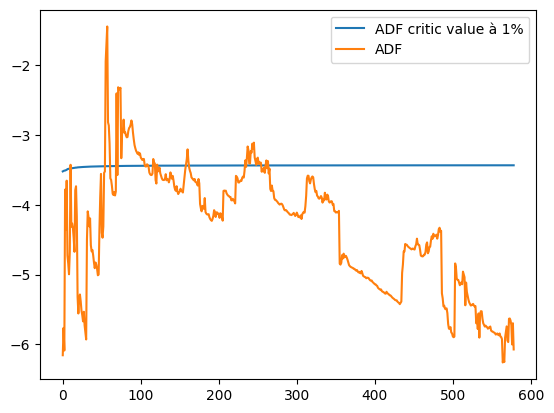

In [380]:
plt.plot(adf_critic_value_15[10:],label="ADF critic value à 1%")
plt.plot(adf_stats_list_15[10:],label = "ADF")
plt.legend();

On peut vérifier ci-dessous que l'on réplique bien les indices de hausses et de baisse. 

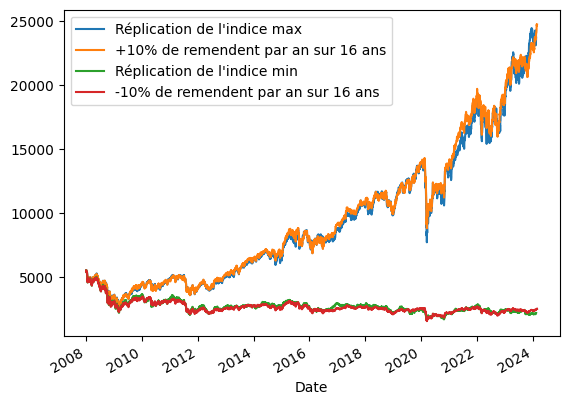

In [381]:
plt.plot(replication_max_10,label="Réplication de l'indice max")
df_plus_10_5y["CAC Index Ajusté"].plot(label="+10% de remendent par an sur 16 ans")

plt.plot(replication_min_10,label="Réplication de l'indice min")
df_min_10_5y["CAC Index Ajusté"].plot(label="-10% de remendent par an sur 16 ans")

plt.legend()
plt.show() 

On a donc mis en place une stratégie qui permet de répliquer les indices longs et courts. Il suffit maintenant de regarder la différence des rendements annuels des deux stratégies. Cela nous donnera le rendement de notre stratégie finale, nous allons pouvoir regarder ces rendements en fonction du temps, le sharpe ratio, la skewness et la kurtosis. 

In [382]:
replication_max_5.resample('M').last().pct_change()

,0
2008-01-31,NaN
2008-02-29,-0.004916
2008-03-31,-0.019896
2008-04-30,0.067760
2008-05-31,0.002279
...,...
2023-10-31,-0.008917
2023-11-30,0.060064
2023-12-31,0.029011
2024-01-31,-0.011273


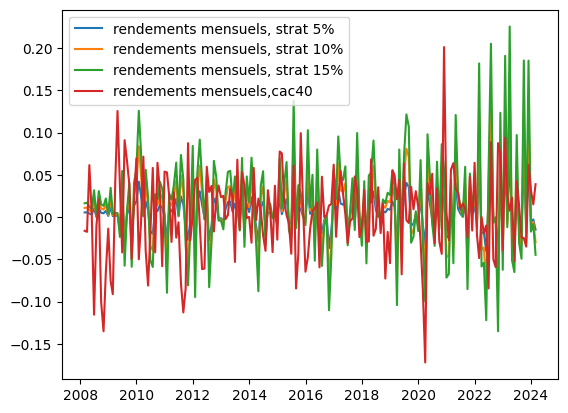

In [383]:
plt.plot((replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()),label="rendements mensuels, strat 5%")
plt.plot((replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()),label="rendements mensuels, strat 10%")
plt.plot((replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()),label="rendements mensuels, strat 15%")
plt.plot((df_data["CAC Index"].loc['2008-01-01':].resample('M').last().pct_change()),label="rendements mensuels,cac40")
plt.legend()

plt.show()

In [384]:
rendements_mensuels_5 = replication_max_5.resample('M').last().pct_change() - replication_min_5.resample('M').last().pct_change()
rendements_mensuels_10 = replication_max_10.resample('M').last().pct_change() - replication_min_10.resample('M').last().pct_change()
rendements_mensuels_10 = replication_max_15.resample('M').last().pct_change() - replication_min_15.resample('M').last().pct_change()
rendement_cac40 = df_data["CAC Index"].loc['2008-01-01':].resample('M').last().pct_change()

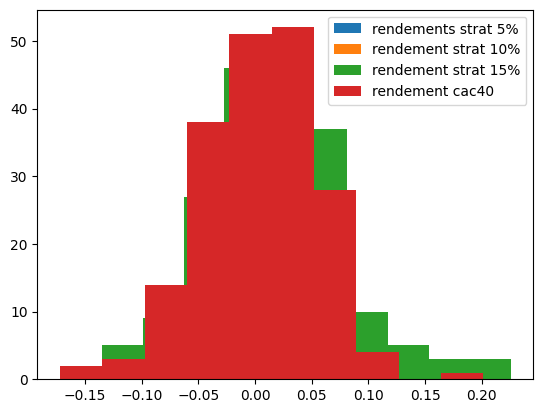

In [386]:
plt.hist(rendements_mensuels_5,label="rendements strat 5%")
plt.hist(rendements_mensuels_10,label="rendement strat 10%")
plt.hist(rendements_mensuels_10,label="rendement strat 15%")
plt.hist(rendement_cac40,label="rendement cac40")
plt.legend();

In [392]:
# e ratio de sharpe final

ratio_sharpe = rendements_mensuels_10.mean()/np.sqrt(rendements_mensuels_10.var()) 
skew =rendements_mensuels_10.skew()
kurtosis = rendements_mensuels_10.kurtosis()

# Pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul.
# On n'a pas repris un taux repo pour le ratio de sharpe. 

print("La skew est :", skew[0]," le ratio de sharpe : ", ratio_sharpe[0]," et le kurtosis", kurtosis[0]) 

La skew est : 0.47475846355858314  le ratio de sharpe :  0.2977268356272922  et le kurtosis 1.2137591795397582


In [393]:
annual_metrics_5 = calculate_annual_global_metrics(replication_max_5, replication_min_5)
annual_metrics_10 = calculate_annual_global_metrics(replication_max_10, replication_min_10)
annual_metrics_15 = calculate_annual_global_metrics(replication_max_15, replication_min_15)

# on calcule les métriques les plus importantes.
annual_metrics_10

,Annual Global Return,Daily mean Return,Daily Variance of Global Return
2008,0.120879,0.000418,0.000018
2009,0.056420,0.000216,0.000042
2010,0.211068,0.000708,0.000062
2011,0.105164,0.000388,0.000069
2012,0.092250,0.000348,0.000070
2013,0.206127,0.000685,0.000031
2014,0.037723,0.000152,0.000037
2015,0.234264,0.000778,0.000058
2016,0.018186,0.000095,0.000063
2017,0.239190,0.000792,0.000057


Pour la stratégie ou je rajoute 5% à l'indice : 

In [397]:
# le ratio de sharpe final

ratio_sharpe = annual_metrics_5["Annual Global Return"].mean()/np.sqrt(annual_metrics_5["Annual Global Return"].var())
skew = annual_metrics_5["Annual Global Return"].skew()
kurtosis = annual_metrics_5["Annual Global Return"].kurtosis()

# pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul.
# on n'a pas repris un taux repo pour le ratio de sharpe. 

print("La skew est :", skew," le ratio de sharpe : ", ratio_sharpe," et le kurtosis", kurtosis)

La skew est : 1.0641222949270965  le ratio de sharpe :  1.3058427530264323  et le kurtosis 2.508846589003141


Pour le cas où l'on a ajouté 10% au rendement :

In [399]:
# le ratio de sharpe final

ratio_sharpe = annual_metrics_10["Annual Global Return"].mean()/np.sqrt(annual_metrics_10["Annual Global Return"].var())
skew = annual_metrics_10["Annual Global Return"].skew()
kurtosis = annual_metrics_10["Annual Global Return"].kurtosis()

# pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul.
# on n'a pas repris un taux repo pour le ratio de sharpe. 

print("La skew est :", skew," le ratio de sharpe : ", ratio_sharpe," et le kurtosis", kurtosis)

La skew est : 1.2438005157823926  le ratio de sharpe :  1.2064137971144617  et le kurtosis 2.806743660785625


Pour un code qui ajoute 15% à la performance :

In [401]:
# le ratio de sharpe final

ratio_sharpe = annual_metrics_15["Annual Global Return"].mean()/np.sqrt(annual_metrics_15["Annual Global Return"].var())
skew = annual_metrics_15["Annual Global Return"].skew()
kurtosis = annual_metrics_15["Annual Global Return"].kurtosis()

# pour calculer le ratio de sharpe, on a fait l'hyp que le taux sans risque est nul.
# on n'a pas repris un taux repo pour le ratio de sharpe. 

print("La skew est :", skew," le ratio de sharpe : ", ratio_sharpe," et le kurtosis", kurtosis)

La skew est : 1.369633114348129  le ratio de sharpe :  1.110452583080307  et le kurtosis 3.004964564501478


Il peut être intéressant aussi de regarder la corrélation des rendements avec les rendements de l'indice. 

Les rendements sont peu corrélés avec ceux de l'indice. Seulement de 14%. 

In [402]:
daily_return_indice = df_data["CAC Index"].loc['2008-01-01':].pct_change().dropna()
daily_return_indice = daily_return_indice.groupby(daily_return_indice.index.year)
daily_return_indice.apply(lambda x: (1 + x).prod() - 1)

Date
2008   -0.420223
2009    0.223234
2010   -0.033419
2011   -0.169516
2012    0.152307
2013    0.179859
2014   -0.005400
2015    0.085264
2016    0.048576
2017    0.092600
2018   -0.109527
2019    0.263676
2020   -0.071369
2021    0.288507
2022   -0.094963
2023    0.165193
2024    0.054514
Name: CAC Index, dtype: float64

In [406]:
print( "Pour la matrice 5% :\n", np.corrcoef(annual_metrics_5["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n") # finalement les rendements annuels ne sont pas corrélés 
print( "Pour la matrice 10% :\n", np.corrcoef(annual_metrics_10["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n")
print( "Pour la matrice 15% :\n", np.corrcoef(annual_metrics_15["Annual Global Return"],daily_return_indice.apply(lambda x: (1 + x).prod() - 1)),"\n")

Pour la matrice 5% :
 [[1.         0.14578492]
 [0.14578492 1.        ]] 

Pour la matrice 10% :
 [[1.         0.15600335]
 [0.15600335 1.        ]] 

Pour la matrice 15% :
 [[1.         0.16436564]
 [0.16436564 1.        ]] 

